In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.models as models
from torchsummary import summary
from matplotlib import pyplot as plt
from collections import namedtuple
import time
from tqdm.notebook import tqdm as tqdm

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Downloading CIFAR10 dataset
dataset = datasets.CIFAR10(root='data', train= True, transform=ToTensor(), download= True)
test_dataset = datasets.CIFAR10(root='data', train= False, transform=ToTensor(), download= True)

100%|██████████| 170498071/170498071 [00:02<00:00, 59347941.90it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
print(len(dataset))
print(len(test_dataset))
print(type(dataset))

50000
10000
<class 'torchvision.datasets.cifar.CIFAR10'>


In [ ]:
print(type(dataset.data))
print(dataset.data.shape)
print(dataset.data.shape)

<class 'numpy.ndarray'>
(50000, 32, 32, 3)
(50000, 32, 32, 3)


torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])
torch.Size([32, 32, 3])


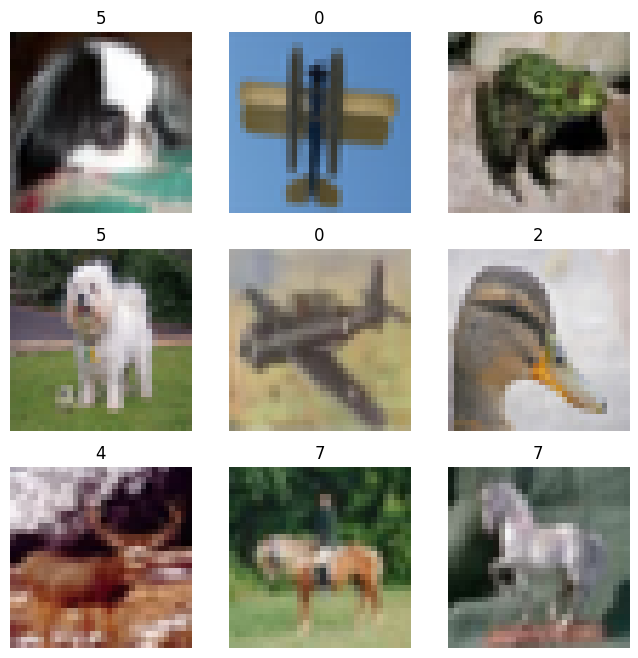

In [ ]:
# Visualizing the Dataset
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.permute(1,2,0))
    print(img.permute(1,2,0).size())
plt.show()

In [ ]:
# split dataset to train_dataset and valid_dataset
num_train = int(len(dataset)*0.9)
num_valid = len(dataset)-num_train
train_dataset, valid_dataset = data.random_split(dataset, [num_train, num_valid])
print(f'The number of training dataset: {len(train_dataset)}')
print(f'The number of valid dataset: {len(valid_dataset)}')
print(f'The number of test dataset: {len(test_dataset)}')

The number of training dataset: 45000
The number of valid dataset: 5000
The number of test dataset: 10000


In [ ]:
BATCH_SIZE = 128
train_iterator = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator = data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)
dataloader_dict={'train':train_iterator, 'val':valid_iterator}
test_iterator = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Define basicblock
class basicblock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual=nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
            )
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU(inplace=True)
        if in_channels != out_channels :
            self.shortcut.add_module('conv',
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride)
                )
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))


    def forward(self,x):
        x=self.residual(x)+self.shortcut(x)
        x=self.relu(x)
        return x

In [ ]:
# Define a bottelneck
class bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.bottleneck=nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels//4, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels//4, out_channels=out_channels//4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels//4, out_channels=out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
            )
        self.shortcut=nn.Sequential()
        if in_channels!=out_channels:
                self.shortcut.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride))
                self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))
        self.relu=nn.ReLU(inplace=True)

    def forward(self, x):
        x=self.bottleneck(x)+self.shortcut(x)
        x=self.relu(x)
        return x


In [ ]:
# Define ResNet model
class ResNet(nn.Module):
    def __init__(self, config, output_dim,in_channels=3):
        super().__init__()
        block, n_blocks, channels = config
        self.channels = channels[0]
        self.cv = nn.Conv2d(in_channels=in_channels, out_channels=self.channels , kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(self.channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layers1 = self.get_res_layers(block, n_blocks[0], channels[0], channels[1])
        self.layers2 = self.get_res_layers(block, n_blocks[1], channels[1], channels[2])
        self.layers3 = self.get_res_layers(block, n_blocks[2], channels[2], channels[3])
        self.layers4 = self.get_res_layers(block, n_blocks[3], channels[3], channels[4])
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(channels[-1], output_dim)

    def get_res_layers(self, block, n_blocks, in_channels, out_channels):
        layers=[]
        if in_channels*2 == out_channels:
            stride=2
        else :
            stride=1
        layers.append(block(in_channels, out_channels, stride))
        for i in range(1, n_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)


    def forward(self, x):
        x=self.cv(x)
        x=self.bn(x)
        x=self.relu(x)
        x=self.maxpool(x)
        x=self.layers1(x)
        x=self.layers2(x)
        x=self.layers3(x)
        x=self.layers4(x)
        x=self.avgpool(x)
        h=x.view(x.shape[0],-1)
        x=self.fc(h)
        return x

In [ ]:
# Define the ResNet config
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [ ]:
ResNet18_config = ResNetConfig(block=basicblock,
                               n_blocks=[2, 2, 2, 2],
                               channels=[64, 64, 128, 256, 512])
ResNet34_config = ResNetConfig(block=basicblock,
                               n_blocks=[3, 4, 6, 3],
                               channels=[64, 64, 128, 256, 512])
ResNet50_config = ResNetConfig(block=bottleneck,
                               n_blocks=[3, 4, 6, 3],
                               channels=[64, 256, 512, 1024, 2048])
ResNet101_config = ResNetConfig(block=bottleneck,
                                n_blocks=[3,4,23,3],
                                channels=[64, 256, 512, 1024, 2048])
ResNet152_config = ResNetConfig(block=bottleneck,
                                n_blocks=[3, 8, 36, 3],
                                channels=[64, 256, 512, 1024, 2048])

In [ ]:
#Make an object
ResNet50 = ResNet(ResNet50_config, output_dim=10)
print(ResNet50)
# origin(-1,1,28,28)
# cv(-1,16,14,14)
# bn(-1,16,14,14)
# max(-1,16,6,6)
# layers1 cv1(-1,16,7,7)
# layers1 bn1(-1,16,7,7)
# layers1 cv2(-1.16,8,8)
# layers1 bn2 (-1,16,8,8)


ResNet(
  (cv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers1): Sequential(
    (0): bottleneck(
      (bottleneck): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (con

In [ ]:
# Define optimizer and loss functions
optimizer = optim.Adam(ResNet50.parameters())
criterion = nn.CrossEntropyLoss()

ResNet50 = ResNet50.to(device)
criterion = criterion.to(device)

In [ ]:
summary(ResNet50, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,640
      BatchNorm2d-14            [-1, 25

In [ ]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch, early_stopping_num):
    since = time.time()
    best_val_loss = float('inf')
    tr_losses=[]
    tr_accs=[]
    val_losses=[]
    val_accs=[]
    i=0

    for epoch in range(num_epoch):
        if i==early_stopping_num:
            break
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-'*30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else :
                model.eval()

            epoch_loss=0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # _ = values, preds = indices
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    # loss.item() makes a tensor of loss as a scalar
                    # size of the inputs of the 0-dim(32?)
                    epoch_loss +=loss.item() * inputs.size(0)
                    epoch_corrects +=torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            if phase=='train':
                tr_losses.append(epoch_loss)
                tr_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                if best_val_loss>epoch_loss:
                    best_val_loss = epoch_loss
                    i=0
                else :
                    i+=1


            print('{} Loss: {:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    return tr_losses, tr_accs, val_losses, val_accs

In [ ]:
EPOCHS=100
tr_losses, tr_accs, val_losses, val_accs = train_model(ResNet50, dataloader_dict, criterion, optimizer, EPOCHS, 100)

Epoch 1/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0804 Acc:0.9713


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3776 Acc:0.7242
Epoch 2/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0792 Acc:0.9728


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2084 Acc:0.7470
Epoch 3/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0784 Acc:0.9731


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3657 Acc:0.7238
Epoch 4/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0750 Acc:0.9745


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4244 Acc:0.7280
Epoch 5/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0669 Acc:0.9768


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8067 Acc:0.6774
Epoch 6/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.3832 Acc:0.8815


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.0831 Acc:0.6562
Epoch 7/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2259 Acc:0.9228


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.1110 Acc:0.7358
Epoch 8/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0562 Acc:0.9817


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3224 Acc:0.7500
Epoch 9/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0378 Acc:0.9875


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5555 Acc:0.7350
Epoch 10/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0475 Acc:0.9832


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4314 Acc:0.7358
Epoch 11/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0482 Acc:0.9833


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4252 Acc:0.7384
Epoch 12/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0458 Acc:0.9844


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7913 Acc:0.6934
Epoch 13/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0529 Acc:0.9816


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4724 Acc:0.7340
Epoch 14/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0474 Acc:0.9836


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3695 Acc:0.7378
Epoch 15/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0457 Acc:0.9838


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4850 Acc:0.7392
Epoch 16/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0527 Acc:0.9822


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3738 Acc:0.7398
Epoch 17/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0411 Acc:0.9861


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5275 Acc:0.7240
Epoch 18/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0481 Acc:0.9844


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4360 Acc:0.7408
Epoch 19/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0451 Acc:0.9844


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4567 Acc:0.7382
Epoch 20/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0434 Acc:0.9852


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5510 Acc:0.7248
Epoch 21/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0429 Acc:0.9850


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4963 Acc:0.7334
Epoch 22/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0424 Acc:0.9853


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6310 Acc:0.7192
Epoch 23/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0392 Acc:0.9868


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4495 Acc:0.7400
Epoch 24/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0381 Acc:0.9864


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6929 Acc:0.7034
Epoch 25/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0740 Acc:0.9764


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4983 Acc:0.7022
Epoch 26/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0446 Acc:0.9852


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6701 Acc:0.7038
Epoch 27/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0367 Acc:0.9884


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4976 Acc:0.7422
Epoch 28/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0244 Acc:0.9922


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6456 Acc:0.7334
Epoch 29/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0574 Acc:0.9806


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5893 Acc:0.7308
Epoch 30/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0278 Acc:0.9902


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5945 Acc:0.7364
Epoch 31/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0247 Acc:0.9914


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6524 Acc:0.7428
Epoch 32/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0459 Acc:0.9850


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5089 Acc:0.7428
Epoch 33/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0268 Acc:0.9910


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5923 Acc:0.7446
Epoch 34/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0306 Acc:0.9898


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5222 Acc:0.7472
Epoch 35/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0282 Acc:0.9906


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5578 Acc:0.7420
Epoch 36/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0283 Acc:0.9905


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5818 Acc:0.7456
Epoch 37/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0300 Acc:0.9896


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6836 Acc:0.7278
Epoch 38/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0275 Acc:0.9908


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5763 Acc:0.7446
Epoch 39/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0275 Acc:0.9905


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4882 Acc:0.7494
Epoch 40/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0286 Acc:0.9904


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6679 Acc:0.7262
Epoch 41/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0268 Acc:0.9909


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5637 Acc:0.7436
Epoch 42/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0248 Acc:0.9916


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6347 Acc:0.7478
Epoch 43/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0292 Acc:0.9901


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8493 Acc:0.7044
Epoch 44/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0286 Acc:0.9908


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5451 Acc:0.7452
Epoch 45/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0265 Acc:0.9906


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5571 Acc:0.7464
Epoch 46/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0278 Acc:0.9904


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6017 Acc:0.7360
Epoch 47/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0213 Acc:0.9927


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6089 Acc:0.7412
Epoch 48/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0218 Acc:0.9925


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5840 Acc:0.7428
Epoch 49/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0215 Acc:0.9928


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6825 Acc:0.7348
Epoch 50/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0244 Acc:0.9918


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7598 Acc:0.7292
Epoch 51/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0238 Acc:0.9922


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6646 Acc:0.7320
Epoch 52/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0220 Acc:0.9929


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7193 Acc:0.7446
Epoch 53/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0198 Acc:0.9936


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5880 Acc:0.7408
Epoch 54/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1138 Acc:0.9688


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3450 Acc:0.7498
Epoch 55/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0117 Acc:0.9964


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.9333 Acc:0.7476
Epoch 56/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0081 Acc:0.9975


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8731 Acc:0.7254
Epoch 57/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0182 Acc:0.9942


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8235 Acc:0.7310
Epoch 58/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0192 Acc:0.9938


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8016 Acc:0.7172
Epoch 59/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0169 Acc:0.9945


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8330 Acc:0.7398
Epoch 60/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0370 Acc:0.9898


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6573 Acc:0.7164
Epoch 61/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0327 Acc:0.9888


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.5497 Acc:0.7520
Epoch 62/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0137 Acc:0.9953


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6215 Acc:0.7468
Epoch 63/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0164 Acc:0.9944


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6513 Acc:0.7498
Epoch 64/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0166 Acc:0.9947


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7201 Acc:0.7448
Epoch 65/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0194 Acc:0.9932


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8342 Acc:0.7302
Epoch 66/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0206 Acc:0.9928


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6608 Acc:0.7440
Epoch 67/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0156 Acc:0.9946


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7372 Acc:0.7346
Epoch 68/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0195 Acc:0.9933


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6154 Acc:0.7470
Epoch 69/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0163 Acc:0.9942


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7114 Acc:0.7526
Epoch 70/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0202 Acc:0.9934


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6451 Acc:0.7422
Epoch 71/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0151 Acc:0.9949


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6495 Acc:0.7480
Epoch 72/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0188 Acc:0.9933


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6372 Acc:0.7420
Epoch 73/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0177 Acc:0.9939


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6837 Acc:0.7528
Epoch 74/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1318 Acc:0.9641


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.0922 Acc:0.6844
Epoch 75/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.1327 Acc:0.9573


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.3031 Acc:0.7480
Epoch 76/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0165 Acc:0.9949


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6380 Acc:0.7540
Epoch 77/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0042 Acc:0.9990


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8331 Acc:0.7540
Epoch 78/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0021 Acc:0.9995


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.9643 Acc:0.7572
Epoch 79/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0027 Acc:0.9990


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 2.1590 Acc:0.7464
Epoch 80/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0070 Acc:0.9976


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 2.0801 Acc:0.7452
Epoch 81/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0108 Acc:0.9966


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 2.0801 Acc:0.7440
Epoch 82/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0150 Acc:0.9947


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8555 Acc:0.7428
Epoch 83/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0094 Acc:0.9969


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.9056 Acc:0.7470
Epoch 84/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0102 Acc:0.9967


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.9103 Acc:0.7452
Epoch 85/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0103 Acc:0.9966


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8836 Acc:0.7502
Epoch 86/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0108 Acc:0.9960


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8838 Acc:0.7494
Epoch 87/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0159 Acc:0.9949


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7088 Acc:0.7464
Epoch 88/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0124 Acc:0.9956


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7375 Acc:0.7494
Epoch 89/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0136 Acc:0.9954


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7262 Acc:0.7452
Epoch 90/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0133 Acc:0.9958


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7482 Acc:0.7354
Epoch 91/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0148 Acc:0.9951


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6545 Acc:0.7484
Epoch 92/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0174 Acc:0.9940


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6594 Acc:0.7428
Epoch 93/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0127 Acc:0.9959


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7235 Acc:0.7386
Epoch 94/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0138 Acc:0.9953


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8469 Acc:0.7380
Epoch 95/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0157 Acc:0.9945


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.8570 Acc:0.7296
Epoch 96/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0168 Acc:0.9944


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6023 Acc:0.7496
Epoch 97/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0117 Acc:0.9963


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.7353 Acc:0.7494
Epoch 98/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0166 Acc:0.9944


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.6416 Acc:0.7506
Epoch 99/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.2053 Acc:0.9366


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.2274 Acc:0.7420
Epoch 100/100
------------------------------


  0%|          | 0/352 [00:00<?, ?it/s]

train Loss: 0.0387 Acc:0.9887


  0%|          | 0/40 [00:00<?, ?it/s]

val Loss: 1.4386 Acc:0.7518
Training complete in 50m 31s


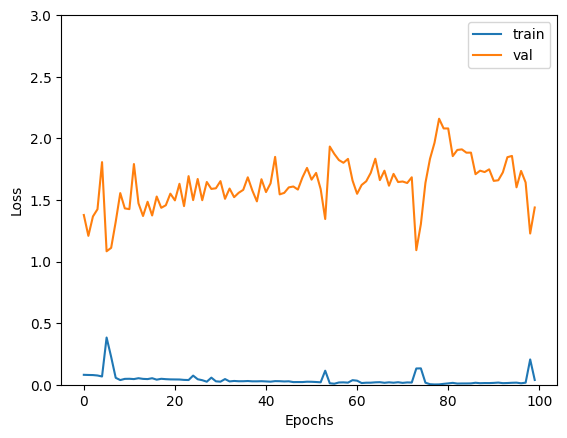

In [ ]:
plt.plot(tr_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,3])
plt.legend(['train', 'val'])
plt.show()

In [ ]:
print(tr_accs)
print(val_accs)

[0.9713111111111111, 0.9728222222222223, 0.9731111111111111, 0.974488888888889, 0.9768, 0.8814888888888889, 0.9228222222222223, 0.9817111111111112, 0.9874666666666667, 0.9832000000000001, 0.9833111111111111, 0.9843777777777778, 0.9816222222222223, 0.9836444444444445, 0.9838222222222223, 0.9821555555555556, 0.9861333333333334, 0.9843777777777778, 0.9844222222222223, 0.9851777777777778, 0.9850222222222222, 0.9853333333333334, 0.9867777777777779, 0.9864222222222223, 0.9764444444444444, 0.9852444444444445, 0.9884222222222223, 0.9922444444444445, 0.9806, 0.9902222222222222, 0.9914222222222223, 0.9850444444444445, 0.9910444444444445, 0.9898444444444445, 0.9906222222222223, 0.9905111111111111, 0.9895555555555556, 0.9908222222222223, 0.990488888888889, 0.9904444444444445, 0.9908666666666667, 0.9916444444444444, 0.9900666666666668, 0.9907555555555556, 0.9906222222222223, 0.9904222222222223, 0.992688888888889, 0.9925333333333334, 0.9928444444444445, 0.9917777777777779, 0.9922222222222222, 0.9929

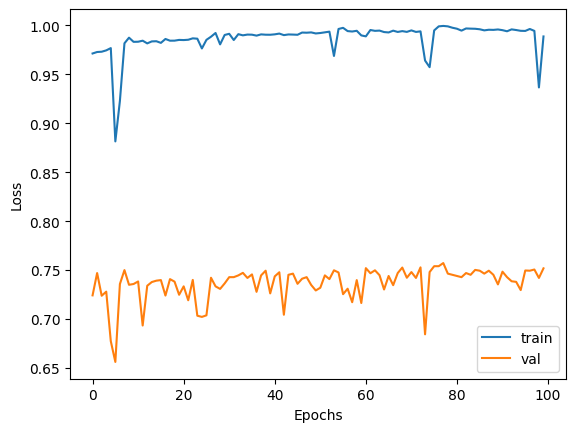

In [ ]:
plt.plot(tr_accs)
plt.plot(val_accs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
def test_model(model, test_iterator):
    since = time.time()
    model.eval()
    corrects = 0
    for inputs, labels in tqdm(test_iterator):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # _ = values, preds = indices
        _, preds = torch.max(outputs, 1)
        corrects +=torch.sum(preds == labels.data)
    acc = corrects.double() / len(test_iterator.dataset)
    acc = acc.item()
    print('Accuracy of the test is {}%'.format(acc*100))
    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))

In [ ]:
test_model(ResNet50, test_iterator)

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the test is 75.55000000000001%
Test complete in 0m 3s
